In [1]:
import keras
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import layers

import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from numba import jit, float64, int64

In [2]:
@jit(nopython=True)
def Race(v, b, ndt=0, dt=0.001):
    x = np.array([0.0, 0.0])
    rt = 0
    ch = -1
    stop = False
    while not stop:
        x[0] += v[0]*dt + np.random.normal(0, 1)*np.sqrt(dt)
        x[1] += v[1]*dt + np.random.normal(0, 1)*np.sqrt(dt)
        rt += dt
        if x[0]>= b and x[1]<b:
            ch = 0.0
            stop = True
        elif x[1]>= b and x[0]<b:
            ch = 1.0
            stop = True
        elif x[0]>= b and x[0]>=b:
            rt = 0
            x = np.array([0.0, 0.0])
    return rt+ndt, ch

In [3]:
data_df = pd.read_csv('../../_00_data/Yang2024_prep.csv', index_col=0)

min_rt = data_df.groupby(by='sbj')['rt'].min()

tr_df, ts_df = data_df.copy(), data_df.copy()

obs_train = np.asarray(data_df[['rt', 'Right', 'sbj']])
X_train = np.asarray(data_df[["o1_a1_val", "o1_a2_val", "o2_a1_val", "o2_a2_val",
                              "o1_a1_gaze", "o1_a2_gaze", "o2_a1_gaze", "o2_a2_gaze"]])

obs_test = np.asarray(data_df[['rt', 'Right', 'sbj']])
X_test = np.asarray(data_df[["o1_a1_val", "o1_a2_val", "o2_a1_val", "o2_a2_val",
                             "o1_a1_gaze", "o1_a2_gaze", "o2_a1_gaze", "o2_a2_gaze"]])

print(X_train.shape, X_test.shape)

(9731, 8) (9731, 8)


In [4]:
def fpt(t, b, v):
    return tf.cast(tf.math.greater(t, 0), tf.float32)*(b/(2*np.pi*t**3)**(1/2) * keras.backend.exp(-1/(2*t) * (v*t-b)**2)) + tf.cast(tf.math.less_equal(t, 0), tf.float32)*0.65**11

def phi(x):
    return 0.5*tf.math.erf(x/tf.sqrt(2.0)) + 0.5

def cdf(t, b, v):
    return tf.cast(tf.math.greater(t, 0), tf.float32)*(phi((v*t-b)/tf.sqrt(t)) + tf.exp(2*v*b)*phi((-v*t-b)/tf.sqrt(t))) + (tf.cast(tf.math.less_equal(t, 0), tf.float32)*0)

def G2(data, pred):

    sbj_indices = tf.cast(data[:, 2], tf.int32)

    # Gather values directly using TensorFlow operations
    gathered_min_rt = tf.gather(min_rt, sbj_indices)
    sigmoid_weights = tf.gather(model.layers[-1].weights[-1], sbj_indices)
    ndt = gathered_min_rt * tf.math.sigmoid(sigmoid_weights)

    thr_weights = tf.gather(model.layers[-1].weights[-2], sbj_indices)
    thr = tf.math.log(1 + tf.exp(thr_weights))

    scl_weights = tf.gather(model.layers[-1].weights[-3], sbj_indices)
    scl = tf.math.log(1 + tf.exp(scl_weights))

    ll1 = (1 - data[:, 1]) * fpt(data[:, 0]-ndt, thr, scl*pred[:, 0]) * (1.0 - cdf(data[:, 0]-ndt, thr, scl*pred[:, 1]))
    ll2 = (data[:, 1]) * fpt(data[:, 0]-ndt, thr, scl*pred[:, 1]) * (1.0 - cdf(data[:, 0]-ndt, thr, scl*pred[:, 0]))

    return -2*tf.reduce_sum(tf.math.log(tf.maximum(ll1 + ll2, 3e-18)), axis=-1)

In [5]:
class Out_layer(keras.layers.Layer):
    def __init__(self, units=2, input_dim=32, n_sbj_prms=10):
        super().__init__()
        self.w = self.add_weight(shape=(input_dim, units), initializer="random_normal", trainable=True)
        self.b = self.add_weight(shape=(units,), initializer="uniform", trainable=True)
        
        self.scaling = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)
        self.threshold = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)
        self.non_decision_time = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)

    def call(self, inputs):
        return tf.math.log(1 + tf.exp(tf.matmul(inputs, self.w) + self.b))
    
def make_model(layers_neuron, input_shape, output_shape, activation, n_sbj_prms):
    keras.backend.clear_session()

    model = keras.Sequential()
    model.add(layers.Input(shape=(input_shape,)))
    
    for l in layers_neuron:
        model.add(layers.Dense(l, activation=activation))
    
    model.add(Out_layer(units=output_shape, input_dim=layers_neuron[-1], n_sbj_prms=n_sbj_prms))

    print(model.summary())
    
    return model

In [6]:
layers_neuron = [10, 10, 8, 5]
input_shape = 8
output_shape = 2
activation = 'tanh'
n_sbj = data_df.sbj.nunique()

model = make_model(layers_neuron, input_shape, output_shape, activation, n_sbj)

model.build()
model.compile(optimizer="RMSprop", loss=G2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                90        
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 8)                 88        
                                                                 
 dense_3 (Dense)             (None, 5)                 45        
                                                                 
 out_layer (Out_layer)       (None, 2)                 96        
                                                                 
Total params: 429 (1.68 KB)
Trainable params: 429 (1.68 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [7]:
sbj_indices = tf.cast(obs_train[:, 2], tf.int32)
obs_train = tf.cast(obs_train, tf.float32)
X_train = tf.convert_to_tensor(X_train)
X_train = tf.cast(X_train, tf.float32)

min_rt = tf.convert_to_tensor(min_rt)
min_rt = tf.cast(min_rt, tf.float32)

In [8]:
history = model.fit(X_train, 
                    obs_train, 
                    shuffle=False, 
                    batch_size=X_train.shape[0], 
                    epochs=5000)

Epoch 1/5000
1/1 [==============================] - 1s 560ms/step - loss: 46434.3438
Epoch 2/5000
1/1 [==============================] - 0s 3ms/step - loss: 46244.9023
Epoch 3/5000
1/1 [==============================] - 0s 3ms/step - loss: 46107.0781
Epoch 4/5000
1/1 [==============================] - 0s 3ms/step - loss: 45990.7734
Epoch 5/5000
1/1 [==============================] - 0s 3ms/step - loss: 45886.8867
Epoch 6/5000
1/1 [==============================] - 0s 3ms/step - loss: 45791.3047
Epoch 7/5000
1/1 [==============================] - 0s 3ms/step - loss: 45701.7148
Epoch 8/5000
1/1 [==============================] - 0s 3ms/step - loss: 45616.6719
Epoch 9/5000
1/1 [==============================] - 0s 3ms/step - loss: 45535.1719
Epoch 10/5000
1/1 [==============================] - 0s 3ms/step - loss: 45456.5312
Epoch 11/5000
1/1 [==============================] - 0s 3ms/step - loss: 45380.2578
Epoch 12/5000
1/1 [==============================] - 0s 3ms/step - loss: 45306.0195

1/1 [==============================] - 0s 4ms/step - loss: 38396.1875
Epoch 195/5000
1/1 [==============================] - 0s 4ms/step - loss: 38373.9062
Epoch 196/5000
1/1 [==============================] - 0s 4ms/step - loss: 38351.7031
Epoch 197/5000
1/1 [==============================] - 0s 4ms/step - loss: 38329.5859
Epoch 198/5000
1/1 [==============================] - 0s 4ms/step - loss: 38307.5469
Epoch 199/5000
1/1 [==============================] - 0s 4ms/step - loss: 38285.5898
Epoch 200/5000
1/1 [==============================] - 0s 4ms/step - loss: 38263.7109
Epoch 201/5000
1/1 [==============================] - 0s 4ms/step - loss: 38241.9141
Epoch 202/5000
1/1 [==============================] - 0s 4ms/step - loss: 38220.1875
Epoch 203/5000
1/1 [==============================] - 0s 4ms/step - loss: 38198.5391
Epoch 204/5000
1/1 [==============================] - 0s 4ms/step - loss: 38176.9688
Epoch 205/5000
1/1 [==============================] - 0s 4ms/step - loss: 38155.

1/1 [==============================] - 0s 4ms/step - loss: 33431.0039
Epoch 387/5000
1/1 [==============================] - 0s 4ms/step - loss: 33399.8828
Epoch 388/5000
1/1 [==============================] - 0s 4ms/step - loss: 33368.6719
Epoch 389/5000
1/1 [==============================] - 0s 4ms/step - loss: 33337.3867
Epoch 390/5000
1/1 [==============================] - 0s 4ms/step - loss: 33306.0391
Epoch 391/5000
1/1 [==============================] - 0s 4ms/step - loss: 33274.6406
Epoch 392/5000
1/1 [==============================] - 0s 4ms/step - loss: 33243.2031
Epoch 393/5000
1/1 [==============================] - 0s 3ms/step - loss: 33211.7266
Epoch 394/5000
1/1 [==============================] - 0s 4ms/step - loss: 33180.2305
Epoch 395/5000
1/1 [==============================] - 0s 4ms/step - loss: 33148.7188
Epoch 396/5000
1/1 [==============================] - 0s 4ms/step - loss: 33117.1953
Epoch 397/5000
1/1 [==============================] - 0s 4ms/step - loss: 33085.

1/1 [==============================] - 0s 4ms/step - loss: 27991.2402
Epoch 579/5000
1/1 [==============================] - 0s 4ms/step - loss: 27970.4434
Epoch 580/5000
1/1 [==============================] - 0s 4ms/step - loss: 27949.1250
Epoch 581/5000
1/1 [==============================] - 0s 4ms/step - loss: 27928.4785
Epoch 582/5000
1/1 [==============================] - 0s 4ms/step - loss: 27907.3047
Epoch 583/5000
1/1 [==============================] - 0s 4ms/step - loss: 27886.8086
Epoch 584/5000
1/1 [==============================] - 0s 4ms/step - loss: 27865.7715
Epoch 585/5000
1/1 [==============================] - 0s 4ms/step - loss: 27845.4160
Epoch 586/5000
1/1 [==============================] - 0s 4ms/step - loss: 27824.5176
Epoch 587/5000
1/1 [==============================] - 0s 4ms/step - loss: 27804.3008
Epoch 588/5000
1/1 [==============================] - 0s 4ms/step - loss: 27783.5410
Epoch 589/5000
1/1 [==============================] - 0s 4ms/step - loss: 27763.

1/1 [==============================] - 0s 4ms/step - loss: 24783.5137
Epoch 771/5000
1/1 [==============================] - 0s 4ms/step - loss: 24770.4805
Epoch 772/5000
1/1 [==============================] - 0s 4ms/step - loss: 24756.5332
Epoch 773/5000
1/1 [==============================] - 0s 4ms/step - loss: 24743.5488
Epoch 774/5000
1/1 [==============================] - 0s 4ms/step - loss: 24729.6523
Epoch 775/5000
1/1 [==============================] - 0s 4ms/step - loss: 24716.7188
Epoch 776/5000
1/1 [==============================] - 0s 4ms/step - loss: 24702.8672
Epoch 777/5000
1/1 [==============================] - 0s 4ms/step - loss: 24689.9844
Epoch 778/5000
1/1 [==============================] - 0s 4ms/step - loss: 24676.1816
Epoch 779/5000
1/1 [==============================] - 0s 4ms/step - loss: 24663.3438
Epoch 780/5000
1/1 [==============================] - 0s 4ms/step - loss: 24649.5898
Epoch 781/5000
1/1 [==============================] - 0s 4ms/step - loss: 24636.

1/1 [==============================] - 0s 4ms/step - loss: 22477.7617
Epoch 963/5000
1/1 [==============================] - 0s 4ms/step - loss: 22466.4141
Epoch 964/5000
1/1 [==============================] - 0s 4ms/step - loss: 22454.6523
Epoch 965/5000
1/1 [==============================] - 0s 4ms/step - loss: 22443.2832
Epoch 966/5000
1/1 [==============================] - 0s 4ms/step - loss: 22431.5176
Epoch 967/5000
1/1 [==============================] - 0s 4ms/step - loss: 22420.1309
Epoch 968/5000
1/1 [==============================] - 0s 4ms/step - loss: 22408.3633
Epoch 969/5000
1/1 [==============================] - 0s 4ms/step - loss: 22396.9492
Epoch 970/5000
1/1 [==============================] - 0s 4ms/step - loss: 22385.1797
Epoch 971/5000
1/1 [==============================] - 0s 4ms/step - loss: 22373.7422
Epoch 972/5000
1/1 [==============================] - 0s 4ms/step - loss: 22361.9531
Epoch 973/5000
1/1 [==============================] - 0s 4ms/step - loss: 22350.

1/1 [==============================] - 0s 4ms/step - loss: 20500.5137
Epoch 1153/5000
1/1 [==============================] - 0s 4ms/step - loss: 20493.1758
Epoch 1154/5000
1/1 [==============================] - 0s 4ms/step - loss: 20482.4414
Epoch 1155/5000
1/1 [==============================] - 0s 4ms/step - loss: 20475.2422
Epoch 1156/5000
1/1 [==============================] - 0s 4ms/step - loss: 20464.7598
Epoch 1157/5000
1/1 [==============================] - 0s 4ms/step - loss: 20457.7676
Epoch 1158/5000
1/1 [==============================] - 0s 4ms/step - loss: 20447.2715
Epoch 1159/5000
1/1 [==============================] - 0s 4ms/step - loss: 20440.3164
Epoch 1160/5000
1/1 [==============================] - 0s 4ms/step - loss: 20429.8086
Epoch 1161/5000
1/1 [==============================] - 0s 4ms/step - loss: 20422.9824
Epoch 1162/5000
1/1 [==============================] - 0s 4ms/step - loss: 20412.5586
Epoch 1163/5000
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 4ms/step - loss: 19092.0625
Epoch 1343/5000
1/1 [==============================] - 0s 4ms/step - loss: 19092.3086
Epoch 1344/5000
1/1 [==============================] - 0s 4ms/step - loss: 19079.6855
Epoch 1345/5000
1/1 [==============================] - 0s 4ms/step - loss: 19079.9043
Epoch 1346/5000
1/1 [==============================] - 0s 4ms/step - loss: 19067.8008
Epoch 1347/5000
1/1 [==============================] - 0s 5ms/step - loss: 19068.4141
Epoch 1348/5000
1/1 [==============================] - 0s 4ms/step - loss: 19055.8145
Epoch 1349/5000
1/1 [==============================] - 0s 5ms/step - loss: 19056.4980
Epoch 1350/5000
1/1 [==============================] - 0s 5ms/step - loss: 19044.2578
Epoch 1351/5000
1/1 [==============================] - 0s 5ms/step - loss: 19044.9590
Epoch 1352/5000
1/1 [==============================] - 0s 4ms/step - loss: 19032.1484
Epoch 1353/5000
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 4ms/step - loss: 18271.3516
Epoch 1533/5000
1/1 [==============================] - 0s 4ms/step - loss: 18215.9551
Epoch 1534/5000
1/1 [==============================] - 0s 4ms/step - loss: 18204.0078
Epoch 1535/5000
1/1 [==============================] - 0s 4ms/step - loss: 18214.7656
Epoch 1536/5000
1/1 [==============================] - 0s 4ms/step - loss: 18259.7539
Epoch 1537/5000
1/1 [==============================] - 0s 4ms/step - loss: 18203.6484
Epoch 1538/5000
1/1 [==============================] - 0s 4ms/step - loss: 18187.3848
Epoch 1539/5000
1/1 [==============================] - 0s 4ms/step - loss: 18196.7461
Epoch 1540/5000
1/1 [==============================] - 0s 4ms/step - loss: 18182.6914
Epoch 1541/5000
1/1 [==============================] - 0s 4ms/step - loss: 18193.2012
Epoch 1542/5000
1/1 [==============================] - 0s 4ms/step - loss: 18180.5195
Epoch 1543/5000
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 4ms/step - loss: 17699.9102
Epoch 1723/5000
1/1 [==============================] - 0s 4ms/step - loss: 17722.4805
Epoch 1724/5000
1/1 [==============================] - 0s 4ms/step - loss: 17763.9297
Epoch 1725/5000
1/1 [==============================] - 0s 4ms/step - loss: 17794.0898
Epoch 1726/5000
1/1 [==============================] - 0s 4ms/step - loss: 17683.3926
Epoch 1727/5000
1/1 [==============================] - 0s 4ms/step - loss: 17690.4375
Epoch 1728/5000
1/1 [==============================] - 0s 4ms/step - loss: 17642.9961
Epoch 1729/5000
1/1 [==============================] - 0s 4ms/step - loss: 17715.7070
Epoch 1730/5000
1/1 [==============================] - 0s 4ms/step - loss: 17706.1035
Epoch 1731/5000
1/1 [==============================] - 0s 4ms/step - loss: 17660.6875
Epoch 1732/5000
1/1 [==============================] - 0s 4ms/step - loss: 17661.4805
Epoch 1733/5000
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 4ms/step - loss: 17415.2168
Epoch 1913/5000
1/1 [==============================] - 0s 4ms/step - loss: 17488.7031
Epoch 1914/5000
1/1 [==============================] - 0s 4ms/step - loss: 17544.7773
Epoch 1915/5000
1/1 [==============================] - 0s 4ms/step - loss: 17540.9297
Epoch 1916/5000
1/1 [==============================] - 0s 4ms/step - loss: 17367.2871
Epoch 1917/5000
1/1 [==============================] - 0s 4ms/step - loss: 17306.6016
Epoch 1918/5000
1/1 [==============================] - 0s 4ms/step - loss: 17294.1133
Epoch 1919/5000
1/1 [==============================] - 0s 4ms/step - loss: 17316.9531
Epoch 1920/5000
1/1 [==============================] - 0s 4ms/step - loss: 17251.9766
Epoch 1921/5000
1/1 [==============================] - 0s 4ms/step - loss: 17319.1211
Epoch 1922/5000
1/1 [==============================] - 0s 4ms/step - loss: 17277.0957
Epoch 1923/5000
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 4ms/step - loss: 17031.5195
Epoch 2103/5000
1/1 [==============================] - 0s 4ms/step - loss: 17027.8633
Epoch 2104/5000
1/1 [==============================] - 0s 4ms/step - loss: 17049.4961
Epoch 2105/5000
1/1 [==============================] - 0s 4ms/step - loss: 17068.5703
Epoch 2106/5000
1/1 [==============================] - 0s 4ms/step - loss: 17128.8828
Epoch 2107/5000
1/1 [==============================] - 0s 4ms/step - loss: 17122.8477
Epoch 2108/5000
1/1 [==============================] - 0s 4ms/step - loss: 17167.2305
Epoch 2109/5000
1/1 [==============================] - 0s 4ms/step - loss: 17087.9258
Epoch 2110/5000
1/1 [==============================] - 0s 4ms/step - loss: 17105.1328
Epoch 2111/5000
1/1 [==============================] - 0s 4ms/step - loss: 17085.7637
Epoch 2112/5000
1/1 [==============================] - 0s 4ms/step - loss: 17179.3711
Epoch 2113/5000
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 4ms/step - loss: 17014.1914
Epoch 2293/5000
1/1 [==============================] - 0s 4ms/step - loss: 16894.1328
Epoch 2294/5000
1/1 [==============================] - 0s 4ms/step - loss: 17006.7207
Epoch 2295/5000
1/1 [==============================] - 0s 4ms/step - loss: 16900.3789
Epoch 2296/5000
1/1 [==============================] - 0s 4ms/step - loss: 16938.5781
Epoch 2297/5000
1/1 [==============================] - 0s 4ms/step - loss: 16904.6758
Epoch 2298/5000
1/1 [==============================] - 0s 4ms/step - loss: 16884.9766
Epoch 2299/5000
1/1 [==============================] - 0s 4ms/step - loss: 16916.5352
Epoch 2300/5000
1/1 [==============================] - 0s 4ms/step - loss: 16962.8848
Epoch 2301/5000
1/1 [==============================] - 0s 4ms/step - loss: 16925.0234
Epoch 2302/5000
1/1 [==============================] - 0s 4ms/step - loss: 16953.2812
Epoch 2303/5000
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 4ms/step - loss: 17055.1191
Epoch 2483/5000
1/1 [==============================] - 0s 4ms/step - loss: 17089.8164
Epoch 2484/5000
1/1 [==============================] - 0s 4ms/step - loss: 17060.2148
Epoch 2485/5000
1/1 [==============================] - 0s 4ms/step - loss: 16857.8789
Epoch 2486/5000
1/1 [==============================] - 0s 4ms/step - loss: 16801.4902
Epoch 2487/5000
1/1 [==============================] - 0s 4ms/step - loss: 16745.1289
Epoch 2488/5000
1/1 [==============================] - 0s 4ms/step - loss: 16742.2441
Epoch 2489/5000
1/1 [==============================] - 0s 4ms/step - loss: 16784.9512
Epoch 2490/5000
1/1 [==============================] - 0s 4ms/step - loss: 16666.2988
Epoch 2491/5000
1/1 [==============================] - 0s 4ms/step - loss: 16668.4414
Epoch 2492/5000
1/1 [==============================] - 0s 4ms/step - loss: 16716.2969
Epoch 2493/5000
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 4ms/step - loss: 16679.3027
Epoch 2673/5000
1/1 [==============================] - 0s 4ms/step - loss: 16582.1074
Epoch 2674/5000
1/1 [==============================] - 0s 4ms/step - loss: 16637.9648
Epoch 2675/5000
1/1 [==============================] - 0s 4ms/step - loss: 16739.2227
Epoch 2676/5000
1/1 [==============================] - 0s 4ms/step - loss: 16784.1211
Epoch 2677/5000
1/1 [==============================] - 0s 4ms/step - loss: 16793.4023
Epoch 2678/5000
1/1 [==============================] - 0s 4ms/step - loss: 16687.9102
Epoch 2679/5000
1/1 [==============================] - 0s 4ms/step - loss: 16643.6348
Epoch 2680/5000
1/1 [==============================] - 0s 4ms/step - loss: 16577.3086
Epoch 2681/5000
1/1 [==============================] - 0s 4ms/step - loss: 16626.4727
Epoch 2682/5000
1/1 [==============================] - 0s 4ms/step - loss: 16581.9277
Epoch 2683/5000
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 4ms/step - loss: 16549.9375
Epoch 2863/5000
1/1 [==============================] - 0s 4ms/step - loss: 16504.7949
Epoch 2864/5000
1/1 [==============================] - 0s 4ms/step - loss: 16510.5977
Epoch 2865/5000
1/1 [==============================] - 0s 4ms/step - loss: 16490.6895
Epoch 2866/5000
1/1 [==============================] - 0s 4ms/step - loss: 16567.0977
Epoch 2867/5000
1/1 [==============================] - 0s 4ms/step - loss: 16494.8086
Epoch 2868/5000
1/1 [==============================] - 0s 4ms/step - loss: 16518.1133
Epoch 2869/5000
1/1 [==============================] - 0s 4ms/step - loss: 16501.1953
Epoch 2870/5000
1/1 [==============================] - 0s 4ms/step - loss: 16600.7305
Epoch 2871/5000
1/1 [==============================] - 0s 4ms/step - loss: 16502.6523
Epoch 2872/5000
1/1 [==============================] - 0s 4ms/step - loss: 16525.2207
Epoch 2873/5000
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 4ms/step - loss: 16363.7363
Epoch 3053/5000
1/1 [==============================] - 0s 4ms/step - loss: 16337.7842
Epoch 3054/5000
1/1 [==============================] - 0s 4ms/step - loss: 16295.2461
Epoch 3055/5000
1/1 [==============================] - 0s 4ms/step - loss: 16325.2070
Epoch 3056/5000
1/1 [==============================] - 0s 4ms/step - loss: 16324.3652
Epoch 3057/5000
1/1 [==============================] - 0s 4ms/step - loss: 16440.6992
Epoch 3058/5000
1/1 [==============================] - 0s 4ms/step - loss: 16452.0332
Epoch 3059/5000
1/1 [==============================] - 0s 4ms/step - loss: 16552.5957
Epoch 3060/5000
1/1 [==============================] - 0s 4ms/step - loss: 16490.7637
Epoch 3061/5000
1/1 [==============================] - 0s 4ms/step - loss: 16529.6211
Epoch 3062/5000
1/1 [==============================] - 0s 4ms/step - loss: 16534.9414
Epoch 3063/5000
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 4ms/step - loss: 16367.4619
Epoch 3243/5000
1/1 [==============================] - 0s 4ms/step - loss: 16391.0762
Epoch 3244/5000
1/1 [==============================] - 0s 4ms/step - loss: 16303.5967
Epoch 3245/5000
1/1 [==============================] - 0s 4ms/step - loss: 16323.8506
Epoch 3246/5000
1/1 [==============================] - 0s 4ms/step - loss: 16333.3252
Epoch 3247/5000
1/1 [==============================] - 0s 4ms/step - loss: 16357.8613
Epoch 3248/5000
1/1 [==============================] - 0s 4ms/step - loss: 16393.1133
Epoch 3249/5000
1/1 [==============================] - 0s 4ms/step - loss: 16408.2148
Epoch 3250/5000
1/1 [==============================] - 0s 4ms/step - loss: 16467.3828
Epoch 3251/5000
1/1 [==============================] - 0s 4ms/step - loss: 16394.2656
Epoch 3252/5000
1/1 [==============================] - 0s 4ms/step - loss: 16357.2617
Epoch 3253/5000
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 4ms/step - loss: 16280.5107
Epoch 3433/5000
1/1 [==============================] - 0s 4ms/step - loss: 16370.6113
Epoch 3434/5000
1/1 [==============================] - 0s 4ms/step - loss: 16289.7891
Epoch 3435/5000
1/1 [==============================] - 0s 4ms/step - loss: 16273.7754
Epoch 3436/5000
1/1 [==============================] - 0s 4ms/step - loss: 16338.5449
Epoch 3437/5000
1/1 [==============================] - 0s 4ms/step - loss: 16255.9404
Epoch 3438/5000
1/1 [==============================] - 0s 4ms/step - loss: 16315.0869
Epoch 3439/5000
1/1 [==============================] - 0s 4ms/step - loss: 16267.1016
Epoch 3440/5000
1/1 [==============================] - 0s 4ms/step - loss: 16272.6729
Epoch 3441/5000
1/1 [==============================] - 0s 4ms/step - loss: 16339.6357
Epoch 3442/5000
1/1 [==============================] - 0s 4ms/step - loss: 16351.9258
Epoch 3443/5000
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 4ms/step - loss: 16184.3564
Epoch 3623/5000
1/1 [==============================] - 0s 4ms/step - loss: 16250.2998
Epoch 3624/5000
1/1 [==============================] - 0s 4ms/step - loss: 16223.7598
Epoch 3625/5000
1/1 [==============================] - 0s 4ms/step - loss: 16284.6963
Epoch 3626/5000
1/1 [==============================] - 0s 4ms/step - loss: 16353.1826
Epoch 3627/5000
1/1 [==============================] - 0s 4ms/step - loss: 16390.0938
Epoch 3628/5000
1/1 [==============================] - 0s 4ms/step - loss: 16244.2354
Epoch 3629/5000
1/1 [==============================] - 0s 4ms/step - loss: 16215.5400
Epoch 3630/5000
1/1 [==============================] - 0s 4ms/step - loss: 16216.1426
Epoch 3631/5000
1/1 [==============================] - 0s 4ms/step - loss: 16226.6885
Epoch 3632/5000
1/1 [==============================] - 0s 4ms/step - loss: 16150.2383
Epoch 3633/5000
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 4ms/step - loss: 16037.1123
Epoch 3813/5000
1/1 [==============================] - 0s 4ms/step - loss: 16045.8770
Epoch 3814/5000
1/1 [==============================] - 0s 4ms/step - loss: 15992.4805
Epoch 3815/5000
1/1 [==============================] - 0s 4ms/step - loss: 16165.7100
Epoch 3816/5000
1/1 [==============================] - 0s 4ms/step - loss: 16092.6758
Epoch 3817/5000
1/1 [==============================] - 0s 4ms/step - loss: 16204.6289
Epoch 3818/5000
1/1 [==============================] - 0s 4ms/step - loss: 16409.3242
Epoch 3819/5000
1/1 [==============================] - 0s 4ms/step - loss: 16426.0918
Epoch 3820/5000
1/1 [==============================] - 0s 4ms/step - loss: 16526.1660
Epoch 3821/5000
1/1 [==============================] - 0s 4ms/step - loss: 16459.4531
Epoch 3822/5000
1/1 [==============================] - 0s 4ms/step - loss: 16339.9346
Epoch 3823/5000
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 4ms/step - loss: 16326.1680
Epoch 4003/5000
1/1 [==============================] - 0s 4ms/step - loss: 16216.0977
Epoch 4004/5000
1/1 [==============================] - 0s 4ms/step - loss: 16287.3193
Epoch 4005/5000
1/1 [==============================] - 0s 4ms/step - loss: 16186.2637
Epoch 4006/5000
1/1 [==============================] - 0s 4ms/step - loss: 16297.5781
Epoch 4007/5000
1/1 [==============================] - 0s 4ms/step - loss: 16112.7402
Epoch 4008/5000
1/1 [==============================] - 0s 4ms/step - loss: 16169.5049
Epoch 4009/5000
1/1 [==============================] - 0s 4ms/step - loss: 16174.8643
Epoch 4010/5000
1/1 [==============================] - 0s 4ms/step - loss: 16089.4873
Epoch 4011/5000
1/1 [==============================] - 0s 4ms/step - loss: 16131.8740
Epoch 4012/5000
1/1 [==============================] - 0s 4ms/step - loss: 16184.0713
Epoch 4013/5000
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 4ms/step - loss: 15998.1387
Epoch 4193/5000
1/1 [==============================] - 0s 4ms/step - loss: 16012.9980
Epoch 4194/5000
1/1 [==============================] - 0s 4ms/step - loss: 16158.7949
Epoch 4195/5000
1/1 [==============================] - 0s 4ms/step - loss: 16412.6113
Epoch 4196/5000
1/1 [==============================] - 0s 4ms/step - loss: 16321.5322
Epoch 4197/5000
1/1 [==============================] - 0s 4ms/step - loss: 16150.4863
Epoch 4198/5000
1/1 [==============================] - 0s 4ms/step - loss: 16156.9219
Epoch 4199/5000
1/1 [==============================] - 0s 4ms/step - loss: 16058.0381
Epoch 4200/5000
1/1 [==============================] - 0s 4ms/step - loss: 16049.0176
Epoch 4201/5000
1/1 [==============================] - 0s 4ms/step - loss: 15968.0332
Epoch 4202/5000
1/1 [==============================] - 0s 4ms/step - loss: 16010.9668
Epoch 4203/5000
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 4ms/step - loss: 16034.6699
Epoch 4383/5000
1/1 [==============================] - 0s 4ms/step - loss: 15989.8193
Epoch 4384/5000
1/1 [==============================] - 0s 4ms/step - loss: 15993.5430
Epoch 4385/5000
1/1 [==============================] - 0s 4ms/step - loss: 16076.7842
Epoch 4386/5000
1/1 [==============================] - 0s 4ms/step - loss: 16036.1416
Epoch 4387/5000
1/1 [==============================] - 0s 4ms/step - loss: 16093.7373
Epoch 4388/5000
1/1 [==============================] - 0s 4ms/step - loss: 16190.5303
Epoch 4389/5000
1/1 [==============================] - 0s 4ms/step - loss: 16223.9111
Epoch 4390/5000
1/1 [==============================] - 0s 4ms/step - loss: 16246.1475
Epoch 4391/5000
1/1 [==============================] - 0s 4ms/step - loss: 16288.6201
Epoch 4392/5000
1/1 [==============================] - 0s 4ms/step - loss: 16107.4131
Epoch 4393/5000
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 4ms/step - loss: 16091.5488
Epoch 4573/5000
1/1 [==============================] - 0s 4ms/step - loss: 15927.8975
Epoch 4574/5000
1/1 [==============================] - 0s 4ms/step - loss: 16063.9873
Epoch 4575/5000
1/1 [==============================] - 0s 4ms/step - loss: 15975.5205
Epoch 4576/5000
1/1 [==============================] - 0s 4ms/step - loss: 16151.6807
Epoch 4577/5000
1/1 [==============================] - 0s 4ms/step - loss: 16303.1680
Epoch 4578/5000
1/1 [==============================] - 0s 3ms/step - loss: 16041.0215
Epoch 4579/5000
1/1 [==============================] - 0s 4ms/step - loss: 16079.7275
Epoch 4580/5000
1/1 [==============================] - 0s 4ms/step - loss: 16101.8457
Epoch 4581/5000
1/1 [==============================] - 0s 4ms/step - loss: 15904.6875
Epoch 4582/5000
1/1 [==============================] - 0s 4ms/step - loss: 15884.9863
Epoch 4583/5000
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 4ms/step - loss: 16240.7100
Epoch 4763/5000
1/1 [==============================] - 0s 4ms/step - loss: 16445.3906
Epoch 4764/5000
1/1 [==============================] - 0s 4ms/step - loss: 16136.9873
Epoch 4765/5000
1/1 [==============================] - 0s 4ms/step - loss: 16150.0430
Epoch 4766/5000
1/1 [==============================] - 0s 4ms/step - loss: 16272.7100
Epoch 4767/5000
1/1 [==============================] - 0s 4ms/step - loss: 16054.2070
Epoch 4768/5000
1/1 [==============================] - 0s 4ms/step - loss: 16056.1123
Epoch 4769/5000
1/1 [==============================] - 0s 4ms/step - loss: 15932.5459
Epoch 4770/5000
1/1 [==============================] - 0s 4ms/step - loss: 15913.2656
Epoch 4771/5000
1/1 [==============================] - 0s 4ms/step - loss: 15860.4805
Epoch 4772/5000
1/1 [==============================] - 0s 4ms/step - loss: 15944.7100
Epoch 4773/5000
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 4ms/step - loss: 15962.5527
Epoch 4953/5000
1/1 [==============================] - 0s 4ms/step - loss: 15876.2734
Epoch 4954/5000
1/1 [==============================] - 0s 4ms/step - loss: 15887.3057
Epoch 4955/5000
1/1 [==============================] - 0s 4ms/step - loss: 15898.4082
Epoch 4956/5000
1/1 [==============================] - 0s 4ms/step - loss: 15869.3203
Epoch 4957/5000
1/1 [==============================] - 0s 4ms/step - loss: 15841.8691
Epoch 4958/5000
1/1 [==============================] - 0s 4ms/step - loss: 15878.2051
Epoch 4959/5000
1/1 [==============================] - 0s 4ms/step - loss: 15899.8037
Epoch 4960/5000
1/1 [==============================] - 0s 4ms/step - loss: 15988.3340
Epoch 4961/5000
1/1 [==============================] - 0s 4ms/step - loss: 18314.7461
Epoch 4962/5000
1/1 [==============================] - 0s 4ms/step - loss: 15869.7373
Epoch 4963/5000
1/1 [==============================] - 0s 4ms/step - l

In [9]:
pred_v = model.predict(X_test)
threshold = np.asanyarray(tf.math.log(1 + tf.exp(model.layers[-1].weights[-2])))
ndt = np.asanyarray(np.asanyarray(min_rt)*tf.math.sigmoid(model.layers[-1].weights[-1]))

305/305 [==============================] - 0s 298us/step


In [10]:
pred_bhv = {'sbj': [],
            'rt': [],
            'ch': [],
            'value_diff': [],
            'gaze_diff': []}

scaling = np.asanyarray(tf.math.log(1 + tf.exp(model.layers[-1].weights[-3])))
scaling = np.asanyarray([scaling[i] for i in ts_df['sbj']])

for n in range(20):
    for s in range(ts_df.shape[0]):
        rt, ch = Race(scaling[s]*pred_v[s,:], threshold[ts_df.sbj[s]], ndt[ts_df.sbj[s]])
        pred_bhv['sbj'].append(ts_df.sbj[s])
        pred_bhv['rt'].append(rt)
        pred_bhv['ch'].append(ch)
        pred_bhv['value_diff'].append(ts_df['Right Value - Left Value'][s])
        pred_bhv['gaze_diff'].append(ts_df['Dwell Time Advantage (R - L)'][s])
        
pred_bhv = pd.DataFrame(pred_bhv)

In [11]:
pred_bhv.to_csv('Yang_complete.csv')

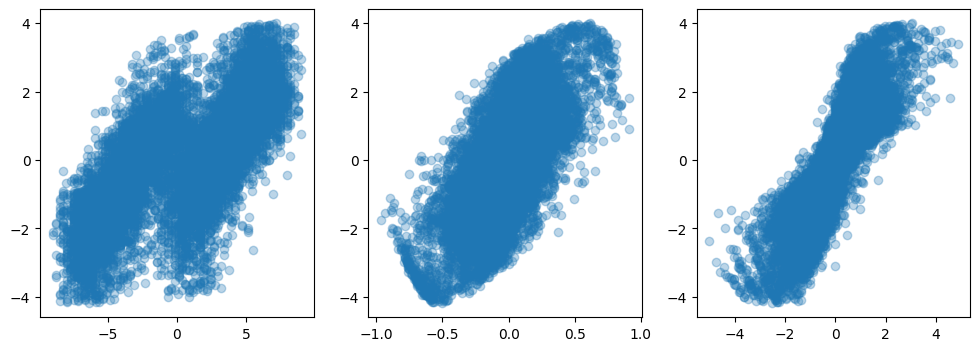

In [13]:
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.scatter(X_test[:, 0] + X_test[:, 1] - X_test[:, 2] - X_test[:, 3], 
            pred_v[:, 0] - pred_v[:, 1], alpha=0.3);

plt.subplot(132)
plt.scatter(X_test[:, 4] + X_test[:, 5] - X_test[:, 6] - X_test[:, 7], 
            pred_v[:, 0] - pred_v[:, 1], alpha=0.3);

plt.subplot(133)
a1 = X_test[:, 0]*X_test[:, 4] +X_test[:, 1]*X_test[:, 5]
a2 = X_test[:, 2]*X_test[:, 6] +X_test[:, 3]*X_test[:, 7]
plt.scatter(a1 - a2, pred_v[:, 0] - pred_v[:, 1], alpha=0.3);

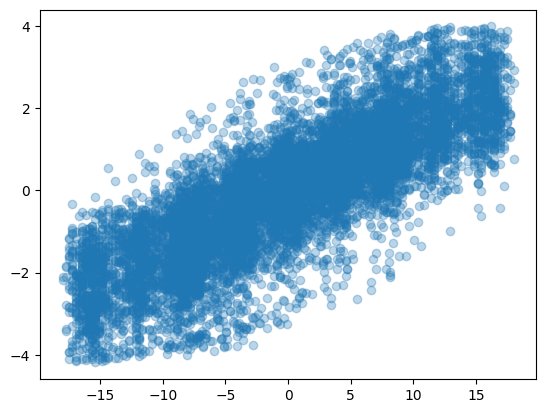

In [14]:
plt.scatter(4*X_test[:, 0] + X_test[:, 1] - 4*X_test[:, 2] - X_test[:, 3], 
            pred_v[:, 0] - pred_v[:, 1], alpha=0.3);